# FD_1D_DX4_DT3_ABS_fast 1-D acoustic Finite-Difference modelling

GNU General Public License v3.0

Author: Florian Wittkamp

Finite-Difference acoustic seismic wave simulation
Discretization of the first-order acoustic wave equation

Temporal second-order accuracy $O(\Delta T^3)$

Spatial fourth-order accuracy  $O(\Delta X^4)$

Temporal discretization is based on the Adams-Basforth method
Theory is available in:

Bohlen, T., & Wittkamp, F. (2016).
Three-dimensional viscoelastic time-domain finite-difference seismic modelling using the staggered Adams-Bashforth time integrator.

Geophysical Journal International, 204(3), 1781-1788.

##  Initialisation

In [1]:
%matplotlib inline
import numpy as np
import time as tm
import matplotlib.pyplot as plt

## Input Parameter

In [2]:
# Discretization
c1=20   # Number of grid points per dominant wavelength
c2=0.5  # CFL-Number
nx=2000 # Number of grid points
T=10     # Total propagation time

# Source Signal
f0= 10      # Center frequency Ricker-wavelet
q0= 1       # Maximum amplitude Ricker-Wavelet
xscr = 100  # Source position (in grid points)

# Receiver
xrec1=400  # Position Reciever 1 (in grid points)
xrec2=800  # Position Reciever 2 (in grid points)
xrec3=1800 # Position Reciever 3 (in grid points)

# Velocity and density
modell_v = np.hstack((1000*np.ones((np.int(nx/2))),1500*np.ones((np.int(nx/2)))))
rho=np.hstack((1*np.ones((np.int(nx/2))),1.5*np.ones((np.int(nx/2)))))

## Preparation

In [3]:
# Init wavefields
vx=np.zeros(nx)
p=np.zeros(nx)
vx_x=np.zeros((nx),float)
p_x=np.zeros((nx),float)
vx_x2=np.zeros((nx),float)
p_x2=np.zeros((nx),float)
vx_x3=np.zeros((nx),float)
p_x3=np.zeros((nx),float)

# Calculate first Lame-Paramter
l=rho * modell_v * modell_v

cmin=min(modell_v.flatten())  # Lowest P-wave velocity
cmax=max(modell_v.flatten())  # Highest P-wave velocity
fmax=2*f0                     # Maximum frequency
dx=cmin/(fmax*c1)             # Spatial discretization (in m)
dt=dx/(cmax)*c2               # Temporal discretization (in s)
lampda_min=cmin/fmax          # Smallest wavelength

# Output model parameter:
print("Model size: x:",dx*nx,"in m")
print("Temporal discretization: ",dt," s")
print("Spatial discretization: ",dx," m")
print("Number of gridpoints per minimum wavelength: ",lampda_min/dx)

Model size: x: 5000.0 in m
Temporal discretization:  0.0008333333333333334  s
Spatial discretization:  2.5  m
Number of gridpoints per minimum wavelength:  20.0


## Create space and time vector

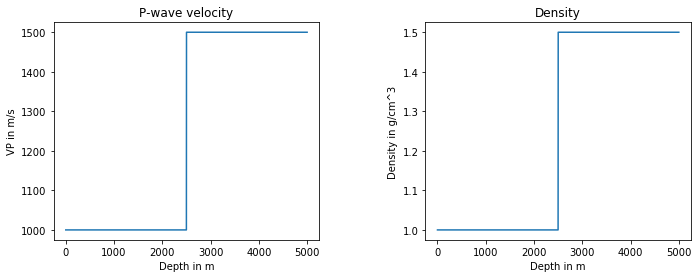

In [4]:
x=np.arange(0,dx*nx,dx) # Space vector
t=np.arange(0,T,dt)     # Time vector
nt=np.size(t)           # Number of time steps

# Plotting model
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.subplots_adjust(wspace=0.4,right=1.6)
ax1.plot(x,modell_v)
ax1.set_ylabel('VP in m/s')
ax1.set_xlabel('Depth in m')
ax1.set_title('P-wave velocity')

ax2.plot(x,rho)
ax2.set_ylabel('Density in g/cm^3')
ax2.set_xlabel('Depth in m')
ax2.set_title('Density');

## Source signal - Ricker-wavelet

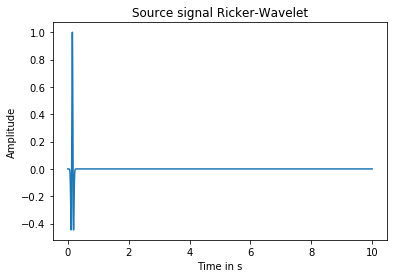

In [5]:
tau=np.pi*f0*(t-1.5/f0)
q=q0*(1.0-2.0*tau**2.0)*np.exp(-tau**2)

# Plotting source signal
plt.figure(3)
plt.plot(t,q)
plt.title('Source signal Ricker-Wavelet')
plt.ylabel('Amplitude')
plt.xlabel('Time in s')
plt.draw()

## Time stepping

In [6]:
# Init Seismograms
Seismogramm=np.zeros((3,nt)); # Three seismograms

# Calculation of some coefficients
i_dx=1.0/(dx)
kx=np.arange(5,nx-4)

print("Starting time stepping...")
## Time stepping
for n in range(2,nt):

        # Inject source wavelet
        p[xscr]=p[xscr]+q[n]

        # Calculating spatial derivative
        p_x[kx]=i_dx*9.0/8.0*(p[kx+1]-p[kx])-i_dx*1.0/24.0*(p[kx+2]-p[kx-1])

        # Update velocity
        vx[kx]=vx[kx]-dt/rho[kx]*(25.0/24.0*p_x[kx]-1.0/12.0*p_x2[kx]+1.0/24.0*p_x3[kx])

        # Save old spatial derivations for Adam-Bashforth method
        np.copyto(p_x3,p_x2)
        np.copyto(p_x2,p_x)

        # Calculating spatial derivative
        vx_x[kx]=i_dx*9.0/8.0*(vx[kx]-vx[kx-1])-i_dx*1.0/24.0*(vx[kx+1]-vx[kx-2])

        # Update pressure
        p[kx]=p[kx]-l[kx]*dt*(25.0/24.0*vx_x[kx]-1.0/12.0*vx_x2[kx]+1.0/24.0*vx_x3[kx])

        # Save old spatial derivations for Adam-Bashforth method
        np.copyto(vx_x3,vx_x2)
        np.copyto(vx_x2,vx_x)

        # Save seismograms
        Seismogramm[0,n]=p[xrec1]
        Seismogramm[1,n]=p[xrec2]
        Seismogramm[2,n]=p[xrec3]
        
print("Finished time stepping!")

Starting time stepping...
Finished time stepping!


## Save seismograms

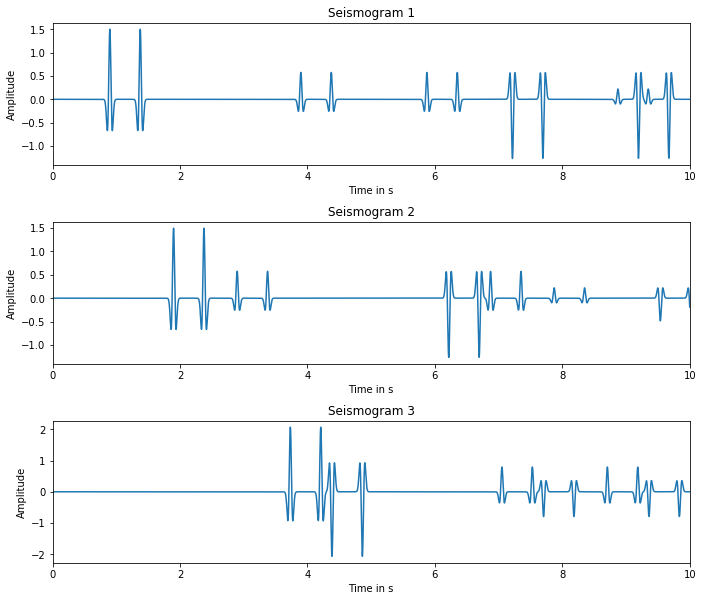

In [7]:
## Save seismograms
np.save("Seismograms/FD_1D_DX4_DT3_ABS_fast",Seismogramm)

## Plot seismograms
fig, (ax1, ax2, ax3) = plt.subplots(3, 1)
fig.subplots_adjust(hspace=0.4,right=1.6, top = 2 )

ax1.plot(t,Seismogramm[0,:])
ax1.set_title('Seismogram 1')
ax1.set_ylabel('Amplitude')
ax1.set_xlabel('Time in s')
ax1.set_xlim(0, T)

ax2.plot(t,Seismogramm[1,:])
ax2.set_title('Seismogram 2')
ax2.set_ylabel('Amplitude')
ax2.set_xlabel('Time in s')
ax2.set_xlim(0, T)

ax3.plot(t,Seismogramm[2,:])
ax3.set_title('Seismogram 3')
ax3.set_ylabel('Amplitude')
ax3.set_xlabel('Time in s')
ax3.set_xlim(0, T);
